In [ ]:
! pip3 install transformers

     |████████████████████████████████| 2.2MB 18.2MB/s 
     |████████████████████████████████| 870kB 48.4MB/s 
     |████████████████████████████████| 3.3MB 54.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=07373641e8f20c94caee88dcab40aaa79e73d5d4aac4612e069cc866f5b8b89f
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import numpy as np
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForMaskedLM

In [ ]:
MaskedLM_model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def create_margins(tokenizer, model, sentence_a, sentence_b=None, sigma=1e-5, device='cuda'):
  model.to(device)
  if sentence_b:
    input_ids = tokenizer(sentence_a, sentence_b, return_tensors="pt")['input_ids']
    token_type_ids = tokenizer(sentence_a, sentence_b, return_tensors="pt")['token_type_ids']
  else:
    input_ids = tokenizer(sentence_a, return_tensors="pt")['input_ids']
    token_type_ids = tokenizer(sentence_a, return_tensors="pt")['token_type_ids']

  mask_id = tokenizer.convert_tokens_to_ids('[MASK]')
  input_batch = input_ids.clone()
  probs = [1]
  bins = [1]

  for i in range(1, input_ids.shape[1] - 1):
    prob = []
    masked_input = input_ids.clone().to(device)
    masked_input[0][i] = mask_id
  
    model.eval()
    with torch.no_grad():
      tokens_score = model(masked_input)[0][0][i]
    tokens_score = F.softmax(tokens_score, dim=-1)
    
    ############# modified method ################
    # delete_token_id = input_ids[0][i].item()
    # tokens_score = tokens_score / (tokens_score.sum() - tokens_score[delete_token_id])
    # print(tokens_score.sum())

    # for j in range(len(tokens_score)):
    #   if j != delete_token_id and tokens_score[j] > sigma:
    #     prob.append(tokens_score[j].item())
    #     input_batch = torch.cat((input_batch, input_ids), 0)
    #     input_batch[-1][i] = j

    ############# original method ################
    print(tokens_score.sum())
    for j in range(len(tokens_score)):
      if tokens_score[j] > sigma:
        prob.append(tokens_score[j].item())
        input_batch = torch.cat((input_batch, input_ids), 0)
        input_batch[-1][i] = j
    
    prob = prob / np.sum(prob)
    probs.extend(prob)
    bins.append(bins[-1] + len(prob))

  return input_batch, token_type_ids, probs, bins

In [ ]:
def compute_woe(input_batch, token_type_ids, probs, bins, model, batch_size, label_a, label_b, device="cuda"):
    """ test the model """
    token_type_ids = torch.repeat_interleave(token_type_ids, repeats=input_batch.shape[0], dim=0)
    dataset = TensorDataset(input_batch, token_type_ids)
    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)
    model.to(device)
    
    # Test!
    logger.info("***** Running test *****")
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", batch_size)

    log_probabilities = []

    for batch in tqdm(dataloader, desc="Testing"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(
                                    input_ids = batch[0], 
                                    token_type_ids = batch[1],
                                )[0]
        logsoftmax = nn.LogSoftmax(dim=1)
        log_probability = logsoftmax(logits).detach().cpu().numpy()
        log_probabilities.extend(log_probability)

    log_probabilities = np.array(log_probabilities)
    log_odds = log_probabilities[:, label_a] - log_probabilities[:, label_b]
    prediction = np.argmax(log_probabilities[0])

    probs = [probs[0]] + [-probs[i] for i in range(1, len(probs))]
    woe = log_odds * probs

    WoE = []
    for idx in range(len(bins) - 1):
      WoE.append(woe[0] + np.sum(woe[bins[idx]: bins[idx + 1]]))
    
    print("the prediction is: ", prediction)
    return WoE

In [ ]:
def compute_woe1(input_batch, token_type_ids, probs, bins, model, batch_size, label, device="cuda"):
    """ test the model """
    token_type_ids = torch.repeat_interleave(token_type_ids, repeats=input_batch.shape[0], dim=0)
    dataset = TensorDataset(input_batch, token_type_ids)
    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)
    model.to(device)
    
    # Test!
    logger.info("***** Running test *****")
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", batch_size)

    probabilities = []

    for batch in tqdm(dataloader, desc="Testing"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(
                                    input_ids = batch[0], 
                                    token_type_ids = batch[1],
                                )[0]
        softmax = nn.Softmax(dim=1)
        probability = softmax(logits).detach().cpu().numpy()
        probabilities.extend(probability)

    probabilities = np.array(probabilities)
    log_odds = np.log(probabilities[:, label]) - np.log((1-probabilities[:, label]))
    prediction = np.argmax(probabilities[0])

    probs = [probs[0]] + [-probs[i] for i in range(1, len(probs))]
    woe = log_odds * probs

    WoE = []
    for idx in range(len(bins) - 1):
      WoE.append(woe[0] + np.sum(woe[bins[idx]: bins[idx + 1]]))
    
    print("the prediction is: ", prediction)
    return WoE

In [ ]:
logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )

In [ ]:
# sentence = 'suffers from the lack of a compelling or comprehensible narrative.'
# sentence = 'the best film about baseball to hit theaters since field of dreams .'
# sentence = "if steven soderbergh ' s ` solaris ' is a failure it is a glorious failure ."

sentence_a = 'a big brown dog swims towards the camera .'
sentence_b = 'a dog swims towards the camera .'

In [ ]:
input_batch, token_type_ids, probs, bins = create_margins(tokenizer, MaskedLM_model, sentence_a, sentence_b)

tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')


In [ ]:
input_batch

tensor([[ 101, 2019, 9750,  ..., 3347, 1012,  102],
        [ 101, 1000, 9750,  ..., 3347, 1012,  102],
        [ 101, 1005, 9750,  ..., 3347, 1012,  102],
        ...,
        [ 101, 2019, 9750,  ..., 3347, 1029,  102],
        [ 101, 2019, 9750,  ..., 3347, 1064,  102],
        [ 101, 2019, 9750,  ..., 3347, 2133,  102]])

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('textattack/bert-base-uncased-snli', num_labels=3)

04/13/2021 02:44:22 - INFO - filelock - Lock 140009631922256 acquired on /root/.cache/huggingface/transformers/503aa3ca25ac2de904314b5dd90cbbded5ea1a2b2f86c385501d0e971e0c30e3.64a8c4bcbf603deab65140847c90b0bdca3fc716050c8a4ccd552b8dd6d73e0e.lock


04/13/2021 02:44:22 - INFO - filelock - Lock 140009631922256 released on /root/.cache/huggingface/transformers/503aa3ca25ac2de904314b5dd90cbbded5ea1a2b2f86c385501d0e971e0c30e3.64a8c4bcbf603deab65140847c90b0bdca3fc716050c8a4ccd552b8dd6d73e0e.lock
04/13/2021 02:44:22 - INFO - filelock - Lock 140009632323984 acquired on /root/.cache/huggingface/transformers/1b0aa1ceb19b55f394a6f885c336afce0cbdce242005ffc9f1fec3bd0d9cd6e2.2e6faf6417d8e75941dc42d31b6a3336fe00e3cfce61e6f3bf3c04a38b1f3ab0.lock


04/13/2021 02:44:32 - INFO - filelock - Lock 140009632323984 released on /root/.cache/huggingface/transformers/1b0aa1ceb19b55f394a6f885c336afce0cbdce242005ffc9f1fec3bd0d9cd6e2.2e6faf6417d8e75941dc42d31b6a3336fe00e3cfce61e6f3bf3c04a38b1f3ab0.lock


In [ ]:
WoE = compute_woe(input_batch, token_type_ids, probs, bins, model, batch_size=100, label_a=1, label_b=2)

04/13/2021 03:08:57 - INFO - __main__ - ***** Running test *****
04/13/2021 03:08:57 - INFO - __main__ -   Num examples = 8784
04/13/2021 03:08:57 - INFO - __main__ -   Batch size = 100
Testing: 100%|██████████| 88/88 [00:11<00:00,  7.62it/s]

the prediction is:  1


In [ ]:
WoE1 = compute_woe1(input_batch, token_type_ids, probs, bins, model, batch_size=100, label=1)

04/13/2021 03:22:30 - INFO - __main__ - ***** Running test *****
04/13/2021 03:22:30 - INFO - __main__ -   Num examples = 8784
04/13/2021 03:22:30 - INFO - __main__ -   Batch size = 100
Testing: 100%|██████████| 88/88 [00:11<00:00,  7.38it/s]

the prediction is:  1


In [ ]:
WoE 

[0.08463880561396042,
 0.001769398566492164,
 0.017004191555965775,
 0.0762102481586675,
 1.2096921633286684e-05,
 -0.017067313916848015,
 -0.028907600048981408,
 0.08050678932154565,
 -9.72714558944432e-06,
 7.1237626722009395e-06,
 -1.0901740568058926e-06,
 -1.8844295484043982e-06,
 -0.012028574106260237,
 -0.006514101945613859]

In [ ]:
WoE1

[0.11003650607013427,
 0.2014435171860498,
 0.019503594636916866,
 0.3889315591227538,
 0.12093851045515613,
 -0.2366033003659096,
 -0.029008997135763437,
 0.1030390409019235,
 -0.05614145368190915,
 0.01816011721484312,
 -0.047835848595535246,
 -0.01285102726279419,
 -0.015171393269711508,
 -0.021588382140963702]

In [ ]:
def score_to_color(score, color_limit):

    # lowest = color_limit[0]
    # highest = color_limit[1]
    lowest = -0.5
    highest = 0.5

    if score > highest:
        rgb = [255, 0, 0]
    elif score < lowest:
        rgb = [0, 0, 255]
    elif score > 0:
        frac = (highest - score) / highest
        red = 255
        blue = int(255 * frac)
        green = int(255 * frac)

        rgb = [red, green, blue]
    elif score < 0:
        frac = (lowest - score) / lowest
        blue = 255
        red = int(255 * frac)
        green = int(255 * frac)

        rgb = [red, green, blue]
    else:
        rgb = [255, 255, 255]

    return str(rgb[0]), str(rgb[1]), str(rgb[2])


def continuous_colored_sentence(sentence, att_scores, verbose=True):
    tokenized_sentence = tokenizer.tokenize(sentence)

    color_limit = [np.min(att_scores), np.max(att_scores)]

    colored = []
    joined = []

    for i in range(len(tokenized_sentence)):
        if tokenized_sentence[i][0] == "#":
            tokenized_sentence[i] = tokenized_sentence[i][2:]
            joined.append(1)
        else:
            joined.append(0)

        colors = score_to_color(att_scores[i], color_limit)
        colored.append(
            "\033[48;2;{};{};{}m{}\033[0m".format(
                colors[0], colors[1], colors[2], tokenized_sentence[i],
            )
        )
    sent = ""

    for i, elem in enumerate(colored):
        if joined[i] == 1:
            sent = sent + str(elem)
        else:
            sent = sent + " " + str(elem)

    if verbose:
        print(sent)
    else:
        return sent

In [ ]:
continuous_colored_sentence(sentence, WoE)

 suffers from the lack of a compelling or comprehensible narrative .


In [ ]:
continuous_colored_sentence(sentence, WoE)

 suffers from the lack of a compelling or comprehensible narrative .


In [ ]:
continuous_colored_sentence(sentence, WoE)

 the best film about baseball to hit theaters since field of dreams .


In [ ]:
continuous_colored_sentence(sentence, WoE)

 the best film about baseball to hit theaters since field of dreams .


In [ ]:
continuous_colored_sentence(sentence, WoE)

 if steven soderbergh ' s ` solaris ' is a failure it is a glorious failure .


In [ ]:
continuous_colored_sentence(sentence, WoE)

 if steven soderbergh ' s ` solaris ' is a failure it is a glorious failure .


In [ ]:
continuous_colored_sentence(sentence_a, WoE[:len(tokenizer.tokenize(sentence_a))])
continuous_colored_sentence(sentence_b, WoE[len(tokenizer.tokenize(sentence_b))+1:])

 a big brown dog swims towards the camera .
 a dog swims towards the camera .


In [ ]:
def evaluate_AUC(tokenizer, MaskedLM_model, model, WoE, sentence_a, sentence_b=None, device='cuda'):
  MaskedLM_model.to(device)
  if sentence_b:
    input_ids = tokenizer(sentence_a, sentence_b, return_tensors="pt")['input_ids']
    token_type_ids = tokenizer(sentence_a, sentence_b, return_tensors="pt")['token_type_ids']
  else:
    input_ids = tokenizer(sentence_a, return_tensors="pt")['input_ids']
    token_type_ids = tokenizer(sentence_a, return_tensors="pt")['token_type_ids']

  mask_id = tokenizer.convert_tokens_to_ids('[MASK]')
  input_batch = input_ids.clone()
  input_replaced = input_ids.clone()

  for i in range(len(WoE) // 5):
    idx = np.argsort(-np.array(WoE))[i]
    masked_input = input_ids.clone().to(device)
    masked_input[0][idx+1] = mask_id
  
    MaskedLM_model.eval()
    with torch.no_grad():
      tokens_score = MaskedLM_model(masked_input)[0][0][idx+1]
    tokens_score = F.softmax(tokens_score, dim=-1)
    
    ############# modified method ################
    delete_token_id = input_ids[0][idx+1].item()
    tokens_score = tokens_score / (tokens_score.sum() - tokens_score[delete_token_id])
    tokens_score[delete_token_id] = 0
    print(tokens_score.sum())
    np.random.seed(1)
    sampled_idx = np.random.choice(a=len(tokens_score), size=1, replace=False, p=tokens_score.detach().cpu().numpy())[0]

    input_batch = torch.cat((input_batch, input_replaced), 0)
    input_batch[-1][idx+1] = sampled_idx
    input_replaced = input_batch[-1].unsqueeze(0)

  token_type_ids = torch.repeat_interleave(token_type_ids, repeats=input_batch.shape[0], dim=0)
  print(input_batch)
  dataset = TensorDataset(input_batch, token_type_ids)
  dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=input_batch.shape[0])
  model.to(device)
  for batch in tqdm(dataloader, desc="Testing"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      logits = model(input_ids = batch[0],token_type_ids = batch[1],)[0]
    probs = F.softmax(logits, dim=-1).detach().cpu().numpy()
    prediction = np.argmax(probs[0])
    line = probs[:, prediction]
    AUC = 0.5 * (2 * np.sum(line[1: -1]) + line[0] + line[-1])

    plt.figure()
    plt.plot(range(0, len(WoE) // 5 + 1), line, marker='o')
    print(AUC)

  return line, AUC

Testing: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s]

tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor([[  101,  2065,  7112,  2061,  4063,  4059,  2232,  1005,  1055,  1036,
          5943,  2483,  1005,  2003,  1037,  4945,  2009,  2003,  1037, 14013,
          4945,  1012,   102],
        [  101,  2065,  7112,  2061,  4063,  4059,  2232,  1005,  1055,  1036,
          5943,  2483,  1005,  2003,  1037,  4945,  2009,  2003,  1037, 14013,
          2543,  1012,   102],
        [  101,  2065,  7112,  2061,  4063,  4059,  2232,  1005,  1055,  1036,
          5943,  2483,  1005,  2001,  1037,  4945,  2009,  2003,  1037, 14013,
          2543,  1012,   102],
        [  101,  2065,  7112,  2061,  4063,  4059,  2232,  1005,  1055,  1036,
          5943,  2483,  1036,  2001,  1037,  4945,  2009,  2003,  1037, 14013,
          2543,  1012,   102],
        [  101,  2065,  3854,  2061,  4063,  4059,  2232,  1005,  1055,  1036,
          5943,  2483,  1036,  2001, 

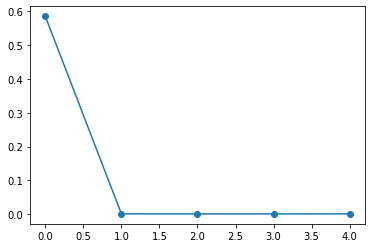

In [ ]:
line, AUC = evaluate_AUC(tokenizer, MaskedLM_model, model, WoE, sentence)

Testing: 100%|██████████| 1/1 [00:00<00:00, 34.65it/s]

tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor([[  101,  1996,  2190,  2143,  2055,  3598,  2000,  2718, 12370,  2144,
          2492,  1997,  5544,  1012,   102],
        [  101,  1996,  2190,  2143,  2055,  3598,  2000,  2718, 12370,  2144,
          2492,  2115,  5544,  1012,   102],
        [  101,  1996,  2190,  2143,  2055,  3598,  2000,  2718, 12370,  2144,
          2492,  2115,  5544,  1025,   102],
        [  101,  1996,  2190,  2143,  2055,  3598,  2000,  2718, 12370,  2144,
          2534,  2115,  5544,  1025,   102],
        [  101,  1996,  2190,  2143,  2055,  3598,  2000,  2718,  2547,  2144,
          2534,  2115,  5544,  1025,   102],
        [  101,  1996,  2190,  2338,  2055,  3598,  2000,  2718,  2547,  2144,
          2534,  2115,  5544,  1025,   102],
        [  101,  1996,  2190,  2338,  2055,  3598,  2018,  2718,

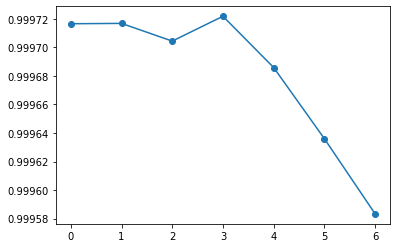

In [ ]:
line, AUC = evaluate_AUC(tokenizer, MaskedLM_model, model, WoE, sentence)